## Data Extracting

### Get crime data from Analyze Boston website
reference like: https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b

- load data from csv file and store in a dataframe using pandas framework <br/>
We also drop column we will not use

In [1]:
import pandas as pd

crime = pd.read_csv('data/crime.csv')
crime['OCCURRED_ON_DATE'] = pd.to_datetime(crime['OCCURRED_ON_DATE'])
crime['Lat'] = pd.to_numeric(crime['Lat'])
crime['Long'] = pd.to_numeric(crime['Long'])
print("strat date:", crime['OCCURRED_ON_DATE'].min())
print("end date:", crime['OCCURRED_ON_DATE'].max())
# drop redundance column
crime = crime.drop(['HOUR', 'Location', 'MONTH', 'REPORTING_AREA','SHOOTING', 'STREET', 'YEAR', 'UCR_PART', 'INCIDENT_NUMBER'], axis=1)
crime.describe()

strat date: 2015-06-15 00:00:00
end date: 2019-11-22 23:14:00


,OFFENSE_CODE,Lat,Long
count,441162.000000,399636.000000,399636.000000
mean,2329.443980,42.221634,-70.920432
std,1181.932776,2.084320,3.371579
min,111.000000,-1.000000,-71.178674
25%,1102.000000,42.297105,-71.097223
50%,3001.000000,42.325538,-71.077619
75%,3201.000000,42.348546,-71.062583
max,3831.000000,42.395042,-1.000000


### Get weather data from csv files
reference like: https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00014739/detail

- load data from csv file and keep only needed column 

In [2]:
weather = pd.read_csv('data/weather.csv')
weather['DATE'] =  pd.to_datetime(weather['DATE']).dt.date
weather = weather[['DATE', 'SNOW', 'TAVG']]
weather.describe()

,SNOW,TAVG
count,1721.000000,1720.000000
mean,0.104358,53.969767
std,0.781500,16.921343
min,0.000000,0.000000
25%,0.000000,40.000000
50%,0.000000,54.000000
75%,0.000000,69.000000
max,14.500000,90.000000


## Data Visualization and Cleaning

### Visualize weather data
We start with weather data because there is only one thing we need which is average tempurature
- Check null value in the dataset

In [3]:
print(weather.isnull().sum(axis=0))

DATE    0
SNOW    0
TAVG    1
dtype: int64


- Find a null value <br/>
Only one data is missing, we will remove this when we finish cleaning and export the cleaned data seet

In [4]:
weather.loc[weather['TAVG'].isnull() == True]

,DATE,SNOW,TAVG
1712,2019-11-07,0.0,NaN


- Plot average tempurature

C:\Users\Chaya\Anaconda3\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Chaya\Anaconda3\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<function matplotlib.pyplot.show(*args, **kw)>

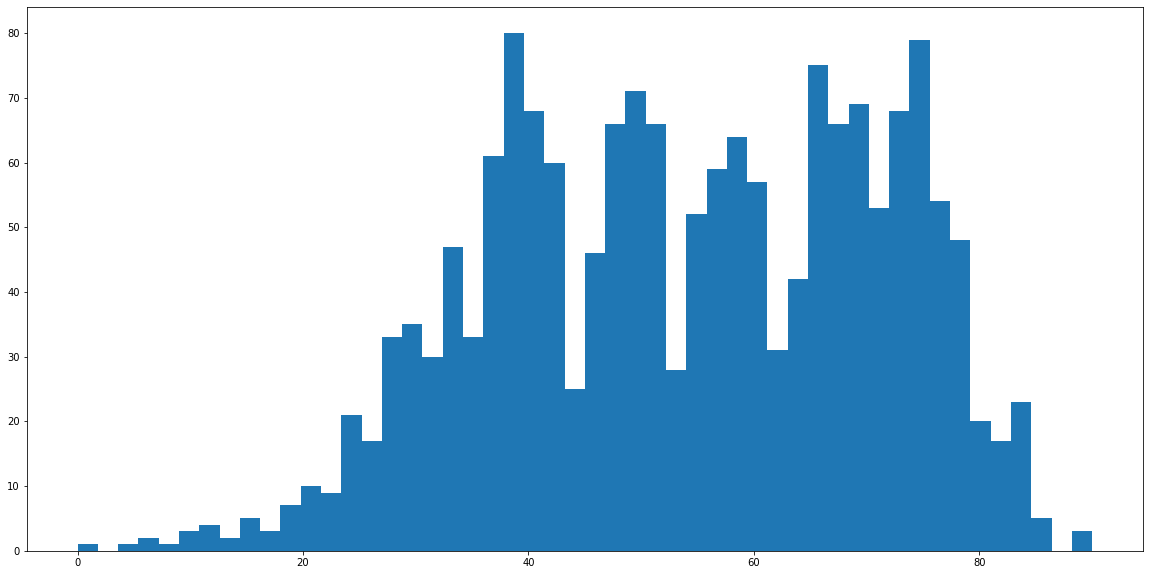

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
plt.hist(weather['TAVG'], 50)
plt.show

### Visualize crime data

- Check null value in data

In [6]:
crime.isnull().sum(axis=0)

OFFENSE_CODE               0
OFFENSE_CODE_GROUP     14322
OFFENSE_DESCRIPTION        0
DISTRICT                2247
OCCURRED_ON_DATE           0
DAY_OF_WEEK                0
Lat                    41526
Long                   41526
dtype: int64

- Romove district that has value "External" <br/>
There are created for test.

In [7]:
crime = crime.drop(crime.loc[crime['DISTRICT'] == 'External'].index.tolist())
crime['DISTRICT'].unique()

array(['D14', 'E13', 'E18', 'D4', 'A15', 'B3', 'A1', 'A7', 'E5', 'B2',
       'C11', 'C6', nan], dtype=object)

- Remove null value that cannot be determinate <br/>
We can use machine learning to fill null value of district and location, <br/>
but if both location and district is null we cannot use that. <br/>
Since, there is only 48 rows from 32,000 that have null values on both location and district, <br/>
we will just remove these rows.

In [8]:
crime.loc[(crime['DISTRICT'].isnull() == True) & ((crime['Lat'].isnull() == True) | (crime['Lat'] == -1))].count()

OFFENSE_CODE           1137
OFFENSE_CODE_GROUP     1059
OFFENSE_DESCRIPTION    1137
DISTRICT                  0
OCCURRED_ON_DATE       1137
DAY_OF_WEEK            1137
Lat                     710
Long                    710
dtype: int64

In [9]:
crime['DISTRICT'] = crime['DISTRICT'].fillna("none")
crime = crime.drop(crime.loc[(crime['DISTRICT'] == 'none') & ((crime['Lat'].isnull() == True) | (crime['Lat'] == -1))].index.tolist())
# we also drop data that have lat and long at -1
crime = crime.drop(crime.loc[crime['Lat'] == -1].index.tolist())
# we also drop data that have external district, there are testing data
crime.loc[(crime['DISTRICT'] == 'none') & ((crime['Lat'].isnull() == True) | (crime['Lat'] == -1))].count()

OFFENSE_CODE           0
OFFENSE_CODE_GROUP     0
OFFENSE_DESCRIPTION    0
DISTRICT               0
OCCURRED_ON_DATE       0
DAY_OF_WEEK            0
Lat                    0
Long                   0
dtype: int64

- Find the mean "Lat" and "Long" of each district for fill null value <br/>

In [10]:
crime_without_null = crime[['DISTRICT', 'Lat', 'Long']]
crime_without_null = crime_without_null.dropna(subset=['Lat', 'Long'])
crime_without_null['Lat'] = pd.to_numeric(crime_without_null['Lat'])
crime_without_null['Long'] = pd.to_numeric(crime_without_null['Long'])
mean_district = crime_without_null.groupby('DISTRICT').mean()
mean_district

,Lat,Long
DISTRICT,,
A1,42.356839,-71.061022
A15,42.375891,-71.062852
A7,42.377494,-71.030591
B2,42.321825,-71.084472
B3,42.287199,-71.085391
C11,42.300923,-71.063578
C6,42.333898,-71.052542
D14,42.350381,-71.142405
D4,42.343669,-71.080818


- Fill Lat and Long null value of each district with its mean lat and long <br/>

In [11]:
crime['Lat'] = crime.apply(lambda x : mean_district[mean_district.index == x['DISTRICT']]['Lat'][0] if not x['Lat'] == x['Lat'] else x['Lat'], axis = 1)
crime['Long'] = crime.apply(lambda x : mean_district[mean_district.index == x['DISTRICT']]['Long'][0] if not x['Long'] == x['Long'] else x['Long'], axis = 1)
crime.isnull().sum()

OFFENSE_CODE               0
OFFENSE_CODE_GROUP     14209
OFFENSE_DESCRIPTION        0
DISTRICT                   0
OCCURRED_ON_DATE           0
DAY_OF_WEEK                0
Lat                        0
Long                       0
dtype: int64

- Plot location of each district<br/>
We can see that none value is all over the place and some location have mislabelled district

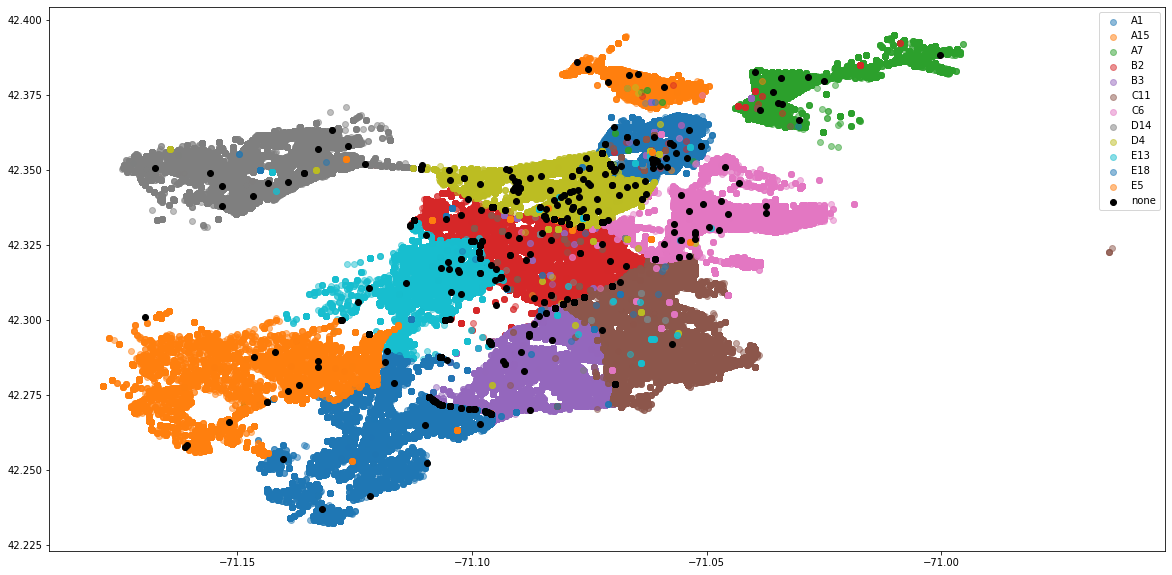

In [12]:
# change all lat and long to number for plot
crime['Lat'] = pd.to_numeric(crime['Lat'])
crime['Long'] = pd.to_numeric(crime['Long'])
# plot each district location
districts = sorted(crime['DISTRICT'].unique())
plt.figure(figsize=(20,10))
for district in districts:
    if district == "none":
        plt.scatter(crime[crime['DISTRICT'] == district]['Long'],crime[crime['DISTRICT'] == district]['Lat'],label=district,alpha = 1, color='black')
    else :
        plt.scatter(crime[crime['DISTRICT'] == district]['Long'],crime[crime['DISTRICT'] == district]['Lat'],label=district,alpha = 0.5)
plt.legend()
plt.show()

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# change none value back to null for train
crime['DISTRICT'] = crime.apply(lambda x : None if x['DISTRICT'] == 'none' else x['DISTRICT'], axis = 1)

# create dataframe for train
trainset = crime[crime['DISTRICT'].isnull() == False][0:21000] # data is unclean should use only some of them
features=list(zip(trainset['Long'],trainset['Lat']))
print(features[0:5])
model = KNeighborsClassifier(n_neighbors=30)

# Train the model using the training sets
model.fit(features,trainset['DISTRICT'])

# Predict Output
predicted = model.predict([[0,2]])
print(predicted)

[(-71.14240531043923, 42.35038099141386), (-71.10640883256197, 42.31462087769463), (-71.11885538315522, 42.26289729744193), (-71.12156299, 42.25951765), (-71.11670964, 42.26209214)]
['C11']


In [14]:
features = list(zip(crime['Long'],crime['Lat']))
predicted = model.predict(features)

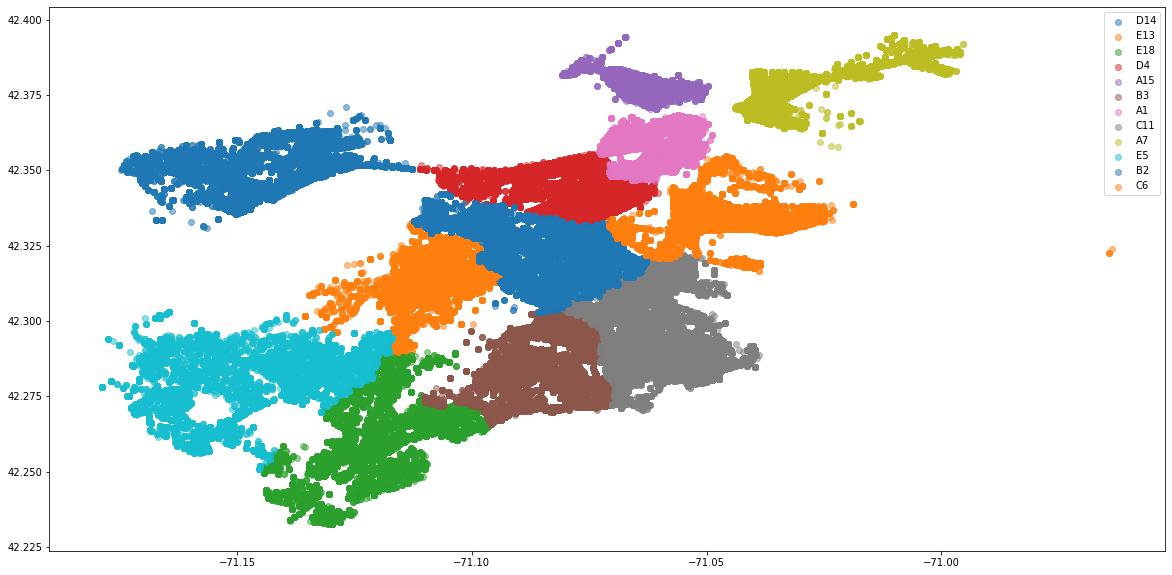

In [15]:
crime['DISTRICT'] = predicted
districts = crime['DISTRICT'].unique().tolist()
plt.figure(figsize=(20,10))
for district in districts:
    plt.scatter(crime[crime['DISTRICT'] == district]['Long'],crime[crime['DISTRICT'] == district]['Lat'],label=district,alpha = 0.5)
plt.legend()
plt.show()

### Export to csv file for analysis

In [16]:
crime['DATE'] = pd.to_datetime(crime['OCCURRED_ON_DATE']).dt.date
crime['TIME'] = pd.to_datetime(crime['OCCURRED_ON_DATE']).dt.time
crimeandweather = pd.merge(crime, weather, on='DATE',  how='left')
crimeandweather.head()

,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,OCCURRED_ON_DATE,DAY_OF_WEEK,Lat,Long,DATE,TIME,SNOW,TAVG
0,3126,NaN,WARRANT ARREST - OUTSIDE OF BOSTON WARRANT,D14,2019-11-22 07:50:00,Friday,42.350381,-71.142405,2019-11-22,07:50:00,NaN,NaN
1,3005,NaN,SICK ASSIST,E13,2019-11-05 18:00:00,Tuesday,42.314621,-71.106409,2019-11-05,18:00:00,0.0,52.0
2,1402,NaN,VANDALISM,E18,2019-11-02 05:09:00,Saturday,42.262897,-71.118855,2019-11-02,05:09:00,0.0,45.0
3,724,Auto Theft,AUTO THEFT,E18,2019-10-13 09:28:24,Sunday,42.259518,-71.121563,2019-10-13,09:28:24,0.0,59.0
4,724,Auto Theft,AUTO THEFT,E18,2019-10-12 20:11:26,Saturday,42.262092,-71.116710,2019-10-12,20:11:26,0.0,56.0


In [17]:
crimeandweather = crimeandweather.dropna(subset=['TAVG'])
crimeandweather.head()

,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,OCCURRED_ON_DATE,DAY_OF_WEEK,Lat,Long,DATE,TIME,SNOW,TAVG
1,3005,NaN,SICK ASSIST,E13,2019-11-05 18:00:00,Tuesday,42.314621,-71.106409,2019-11-05,18:00:00,0.0,52.0
2,1402,NaN,VANDALISM,E18,2019-11-02 05:09:00,Saturday,42.262897,-71.118855,2019-11-02,05:09:00,0.0,45.0
3,724,Auto Theft,AUTO THEFT,E18,2019-10-13 09:28:24,Sunday,42.259518,-71.121563,2019-10-13,09:28:24,0.0,59.0
4,724,Auto Theft,AUTO THEFT,E18,2019-10-12 20:11:26,Saturday,42.262092,-71.116710,2019-10-12,20:11:26,0.0,56.0
5,727,Auto Theft,AUTO THEFT - LEASED/RENTED VEHICLE,D14,2019-10-12 15:12:43,Saturday,42.352375,-71.135096,2019-10-12,15:12:43,0.0,56.0


In [18]:
crimeandweather.to_csv("data/crimeandweather.csv", index=False)